In [2]:
import fpca
###lpr
import numpy as np
import scipy as sp
from scipy import signal
import arrayfire as af
from numba import jit
###fpca
from scipy import interpolate
#我##了5個autojit
import random
###simulation
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time

import pandas as pd
from sklearn import datasets
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
#################################
def EigF1(t):
    return(np.sqrt(2) * np.sin(2 * np.pi * t))

def EigF2(t):
    return(np.sqrt(2) * np.sin(4 * np.pi * t))

def MeanF(t):
    return(np.exp(((t - 0.5)**2)))

def CovF(s, t):
    return(eig_val[0] * EigF1(s) * EigF1(t) + eig_val[1] * EigF2(s) * EigF2(t))

In [4]:
eig_val = np.array([4, 1])
sigma2 = 0.16
num_grid = 401
num_fun = 1000
num_pt = 12
d = 1

t1 = np.linspace(0, 1, num_grid)
t_grid = t1

In [5]:
real_mean = MeanF(t_grid)
real_cov = CovF(t_grid.repeat(num_grid), np.tile(t_grid, num_grid)).reshape(num_grid**2, -1)
real_cov_dia = np.diag(real_cov)
real_eigfun1 = EigF1(t_grid)
real_eigfun2 = EigF2(t_grid)

In [8]:
np.random.seed(101)

t_of_fun = np.random.rand(num_fun, num_pt)

pc_score = np.array((np.random.normal(0, np.sqrt(eig_val[0]), num_fun),
                  np.random.normal(0, np.sqrt(eig_val[1]), num_fun))).reshape(2, num_fun).T

epsilon = np.array(np.random.normal(0, np.sqrt(sigma2), num_pt * num_fun))

eigf1 = EigF1(t_of_fun).reshape(num_fun, num_pt)
eigf2 = EigF2(t_of_fun).reshape(num_fun, num_pt)
meanf = MeanF(t_of_fun).reshape(num_fun, num_pt)
eigf = np.array([eigf1, eigf2])

y = [None] * num_fun
t_of_fun = [None] * num_fun
fun_pt = np.random.randint(2, 13, num_fun)
for n_f in range(num_fun):
    t = np.random.rand(fun_pt.take(n_f), d)
    t_of_fun[n_f] = t
    y[n_f] = MeanF(t).flatten() + np.matmul(np.asarray([EigF1(t), EigF2(t)]).reshape(2, -1).T, pc_score.take(n_f, 0)) + np.random.normal(0, np.sqrt(sigma2), fun_pt[n_f])
    
print('t_of_fun')    
print(t_of_fun[123])
print(np.shape(t_of_fun[123]))
print('y')
print(y[123])
print(np.shape(y[123]))

t_of_fun
[[0.26878046]
 [0.0098407 ]
 [0.15327466]
 [0.688066  ]
 [0.13987681]
 [0.8619475 ]
 [0.6534414 ]]
(7, 1)
y
[ 1.46149116  0.88701192  0.7592628  -0.27069368  0.82265852  1.79966768
 -1.20578848]
(7,)


In [26]:
candidate_h_mean = np.arange(0.06, 0.2, 0.01).reshape(-1, d)
candidate_h_cov = np.arange(0.02, 0.08, 0.005).repeat(2).reshape(-1, 2 * d)
candidate_h_diag_cov = np.arange(0.01, 0.08, 0.005).reshape(-1, d)

In [27]:
fpca.lpr.Set_arrayfire_backend('cpu')
#fpca.lpr.Set_arrayfire_backend('opencl')
#fpca.lpr.Set_arrayfire_backend('cuda')

In [28]:
pre_time = time.time()
result = fpca.Fpca(x = t_of_fun,
                   y = y,
                   x0 = t_grid.reshape(num_grid, d), 
                   h_mean = candidate_h_mean,
                   h_cov = candidate_h_cov,
                   h_cov_dia = candidate_h_diag_cov,
                   fve = 0.9,
                   ker_fun = 'Gaussian')
time.time() - pre_time

108.85969614982605

In [29]:
print(result)

Number of grid: 401
Number of random function: 1000
Eigen pairs: 2
Sigma2: 0.945995
Bandwidth of mean: [0.06]
Bandwidth of cov: [0.05500000000000001, 0.05500000000000001]
Bandwidth of cov_diag: [0.039999999999999994]


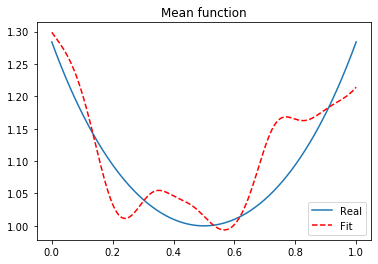

In [30]:
fig1 = plt.figure(1)
plt.plot(t1, real_mean, label = 'Real')
plt.plot(t1, result.mean_fun, '--r', label = 'Fit')
plt.legend(loc = 4)
plt.title('Mean function')
# fig1.savefig('d:/Work_Jupyter/Gpu/Picture/1d_sparse_mean.png')
plt.show()

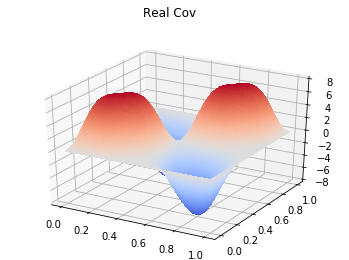

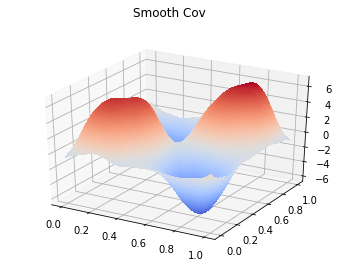

In [31]:
fig1 = plt.figure(1)
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(t1.repeat(t1.size).reshape(num_grid, num_grid), 
                       np.tile(t1, t1.size).reshape(num_grid, num_grid), 
                       real_cov.reshape(num_grid, num_grid),
                       rstride=2, cstride=2, cmap=cm.coolwarm,
                       linewidth=0.1, antialiased=False)
ax.set_zlim3d(-8, 8)
plt.suptitle('Real Cov')

fig2 = plt.figure(2)
ax = fig2.gca(projection='3d')
surf = ax.plot_surface(t1.repeat(t1.size).reshape(num_grid, num_grid), 
                       np.tile(t1, t1.size).reshape(num_grid, num_grid), 
                       result.cov_fun,
                       rstride=2, cstride=2, cmap=cm.coolwarm,
                       linewidth=0.1, antialiased=False)

plt.suptitle('Smooth Cov')
plt.show()

Real eigen values: 4, 1
Fitted eigen values: 3.31048, 0.63384


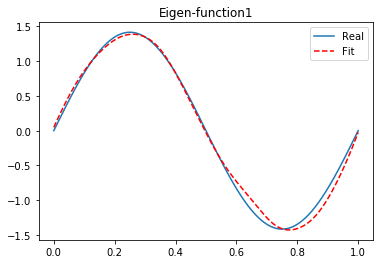

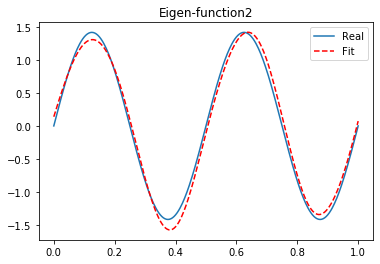

In [32]:
print("Real eigen values: %s" %", ".join(map(str, eig_val)))
print("Fitted eigen values: %s" %", ".join(map(str, np.round(result.eig_val[0:2], 5))))

fig1 = plt.figure(1)
plt.plot(t1, real_eigfun1, label = 'Real')
direction1 = 1 if (real_eigfun1.dot(result.eig_fun[0]) > 0) else -1
plt.plot(t1, direction1 * result.eig_fun[0], '--r', label = 'Fit')
plt.title('Eigen-function1')
plt.legend(loc = 1)
# fig1.savefig('d:/Work_Jupyter/Gpu/Picture/1d_sparse_Eig1.png')

fig2 = plt.figure(2)
plt.plot(t1, real_eigfun2, label = 'Real')
direction2 = 1 if (real_eigfun2.dot(result.eig_fun[1]) > 0) else -1
plt.plot(t1, direction2 * result.eig_fun[1], '--r', label = 'Fit')
plt.title('Eigen-function2')
plt.legend(loc = 1)
# fig2.savefig('d:/Work_Jupyter/Gpu/Picture/1d_sparse_Eig2.png')
plt.show()

In [33]:
print("Real eigen values: %s" %", ".join(map(str, eig_val)))
print("Fitted eigen values: %s" %", ".join(map(str, result.eig_val[0:2])))

Real eigen values: 4, 1
Fitted eigen values: 3.3104753, 0.6338405


In [34]:
print('Estimate fpc scores by PACE')
mse_pc = np.mean((pc_score - result.fpc_scores[:, 0:2] * np.array([direction1, direction2]))**2, axis = 0)
print('MSE of fpc_scores: %s' %", ".join(map(str, mse_pc)))

Estimate fpc scores by PACE
MSE of fpc_scores: 0.1743994544389007, 0.14124577397825056


In [35]:
print("Real Sigma2: %f" %sigma2)
print("Fitted Sigma2: %f" %result.sigma2)

Real Sigma2: 0.160000
Fitted Sigma2: 0.945995


In [36]:
restruct_pc_score, fit_x1_to_x4 = result.Restruct_Fun(t_of_fun[:4], y[:4])

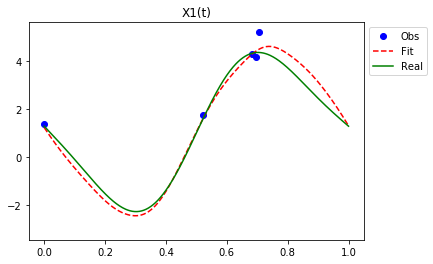

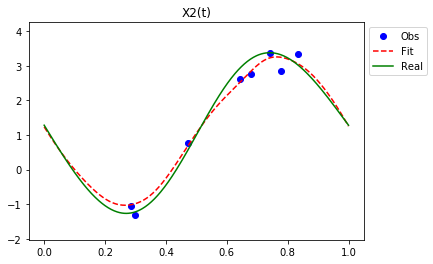

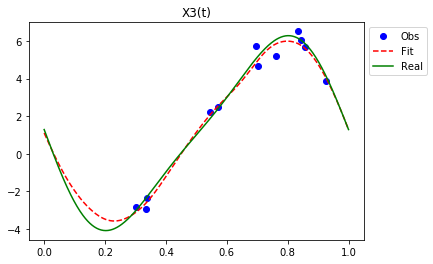

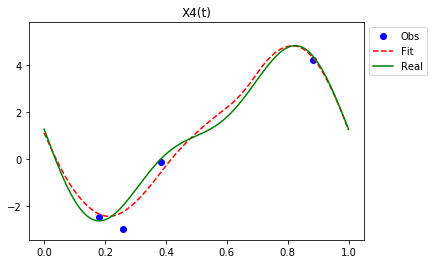

In [17]:
for i in range(4):
    fig = plt.figure(i)
    sort_order = np.argsort(t_of_fun[i].flatten())
    plt.plot(t_of_fun[i][sort_order].flatten(), y[i][sort_order], 'ob', label = 'Obs')
    plt.plot(t1, fit_x1_to_x4[i], '--r', label = 'Fit')
    plt.plot(t1, real_mean + pc_score.take(i, 0).dot(np.asarray([real_eigfun1, real_eigfun2])), 'green', label = 'Real')
    plt.legend(bbox_to_anchor=(1, 1), loc = 2)
    plt.title('X' + str(i + 1) + '(t)')
    plt.ylim(fit_x1_to_x4[i].min() - 1, fit_x1_to_x4[i].max() + 1)
#     fig.savefig('d:/Work_Jupyter/Gpu/Picture/1d_sparse_X' + str(i + 1) + '.png')
plt.show()

In [18]:
dt = 1 / (num_grid - 1)
fit_x = result.Restruct_Fun(t_of_fun, y)[1]
ISE = np.zeros(num_fun)
for i in range(num_fun):
    ISE[i] = ((fit_x.take(i, 0) - (real_mean + pc_score.take(i, 0).dot(np.asarray([real_eigfun1, real_eigfun2]))))**2).sum() * dt
    
MISE = ISE.mean()
print(MISE)

0.3276662607001582
